In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [3]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
import os
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb
import pretrainedmodels

In [9]:
import pandas as pd

In [4]:
from adamW import AdamW

In [4]:
from lr_finder import LRFinder

/opt/anaconda3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [153]:
wandb.init(project="homedepot")

W&B Run: https://app.wandb.ai/homedepot/homedepot/runs/dgupdu59
Call `%%wandb` in the cell containing your training loop to display live results.


W&B Run: https://app.wandb.ai/homedepot/homedepot/runs/dgupdu59

In [5]:
path = 'data'

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
 
data_transforms = {
    'train':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize]),
    'valid':
        transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            normalize])}
 
image_datasets = {
    'train':
        ImageFolder(os.path.join(path,'train'), data_transforms['train']),
    'valid':
        ImageFolder(os.path.join(path,'valid'), data_transforms['valid'])}
 
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=8,
            shuffle=True,
            num_workers=4),
    'valid':
        torch.utils.data.DataLoader(
            image_datasets['valid'],
            batch_size=8,
            shuffle=False,
            num_workers=4)}

In [10]:
#im lazy
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = models.resnet50(pretrained=True).to(device)
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 8).to(device)
    model.load_state_dict(torch.load('testsave.pt'))
    model.eval()

    data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize])
    print('Finished setup')

Finished setup


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True).to(device)

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 8).to(device)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True).to(device)
 
for param in model.parameters():
    param.requires_grad = False

ct = []
for name, child in model.named_children():
    if "maxpool" in ct:
        for params in child.parameters():
           params.requires_grad = True
    ct.append(name)

lr = 1e-5
#optimizer = optim.SGD(list(filter(lambda p: p.requires_grad, model.parameters())), lr=lr, momentum=0.5, weight_decay=1e-4)
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 8).to(device)

criterion = nn.CrossEntropyLoss()

print("[Creating Learning rate scheduler...]")

steps = len(dataloaders['train'])
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)


[Creating Learning rate scheduler...]


In [90]:
optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)




Learning rate search finished. See the graph with {finder_name}.plot()


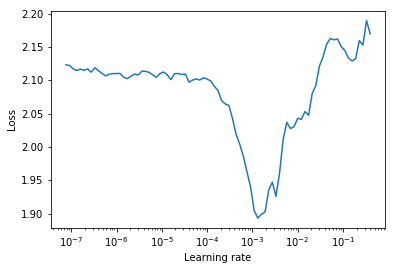

In [60]:
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=1, num_iter=100)
lr_finder.plot()

In [12]:
def train_model(model, criterion, optimizer, dataloaders, scheduler=None, num_epochs=3,cycle_mult=1):

    steps = len(dataloaders['train'])
    completed = 0
    
    best_acc = 0.0
    
    dataset_sizes = {'train':len(dataloaders['train'].dataset),'valid':len(dataloaders['valid'].dataset)}
    
    #wandb.watch(model)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        epoch_loss = 1.0

        for phase in ['train', 'valid']:
            if phase == 'train':
                #if scheduler is not None:
                #    scheduler.step(epoch_loss)
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
 
                if phase == 'train':
                    steps -= 1
                    scheduler.step()
                    #lrval = scheduler.get_lr()
                    #wandb.log({'lr':lrval})
                    #print("lr: ", lrval)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
 
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            if phase == 'valid':
                wandb.log({'epoch_loss':epoch_loss,'epoch_acc':epoch_acc})
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
        lrval = scheduler.get_lr()[0]
        print('steps: %d lr: %.4f'%(steps,lrval))
        
        if (steps <= 0):
            completed += 1
            steps = len(dataloaders['train']) * (completed * cycle_mult)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)
            print(completed)

        #steps = len(dataloaders['train'])
        
        if (completed == 11):
            break;
            
        lrval = scheduler.get_lr()[0]
        print('steps: %d lr: %.4f'%(steps,lrval))
      
    model = model.load_state_dict(best_model_wts)
    return best_acc, model
 


In [8]:
#Regular sgd
def train_model(model, criterion, optimizer, dataloaders, scheduler=None, num_epochs=3,cycle_mult=1):

    steps = len(dataloaders['train'])
    completed = 0
    
    best_acc = 0.0
    
    dataset_sizes = {'train':len(dataloaders['train'].dataset),'valid':len(dataloaders['valid'].dataset)}
    
    #wandb.watch(model)
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
 
        epoch_loss = 1.0

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
 
            running_loss = 0.0
            running_corrects = 0
 
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                outputs = model(inputs)
                loss = criterion(outputs, labels)
 
                if phase == 'train':
                    if scheduler is not None:
                        steps -= 1
                        scheduler.step()
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
 
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
 
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
        
            if phase == 'valid':
                #wandb.log({'epoch_loss':epoch_loss,'epoch_acc':epoch_acc})
                
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
        
        
        if scheduler is not None:
            lrval = scheduler.get_lr()[0]
            print('steps: %d lr: %.8f'%(steps,lrval))
            
        if (steps <= 0):
            steps = len(dataloaders['train'])
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, steps)

        print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                    epoch_loss,
                                                    epoch_acc))    
    
    torch.save(best_model_wts, 'testsave.pt')
    return model

In [9]:
###Using our saved model for inference and the creation of the confusion matrix
classLabels = ['bathroom','bedroom','dining_room','entryway','kitchen','living_room','office','outdoor']

predValues = []
trueValues = []

for inputs, labels in dataloaders['valid']:
    model.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    print(type(inputs))
 
    outputs = model(inputs)
    _,predicted = torch.max(outputs.data, 1)
    
    predList = predicted.tolist()
    labelList = labels.tolist()
    
    for i in range(len(predList)):
        predValues.append(classLabels[predList[i]])
        trueValues.append(classLabels[labelList[i]])

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [19]:
from PIL import Image
import requests
from io import BytesIO

#response = requests.get('https://files.slack.com/files-pri/T03PB1F2E-FLK0DNAFP/img_20190718_133448.jpg')
#img = Image.open(BytesIO(response.content))
img = Image.open('../TestImages/test4.jpg')
img = img.convert('RGB')
img = data_transforms['valid'](img).unsqueeze(0)
img = img.to(device)
outputs = model(img)
_,predicted = torch.max(outputs.data, 1)
print(predicted)

tensor([2], device='cuda:0')


SyntaxError: EOL while scanning string literal (<ipython-input-20-a8168f806f61>, line 1)

[Text(95.09375, 0.5, 'Actual'), Text(0.5, 68.09375, 'Predicted')]

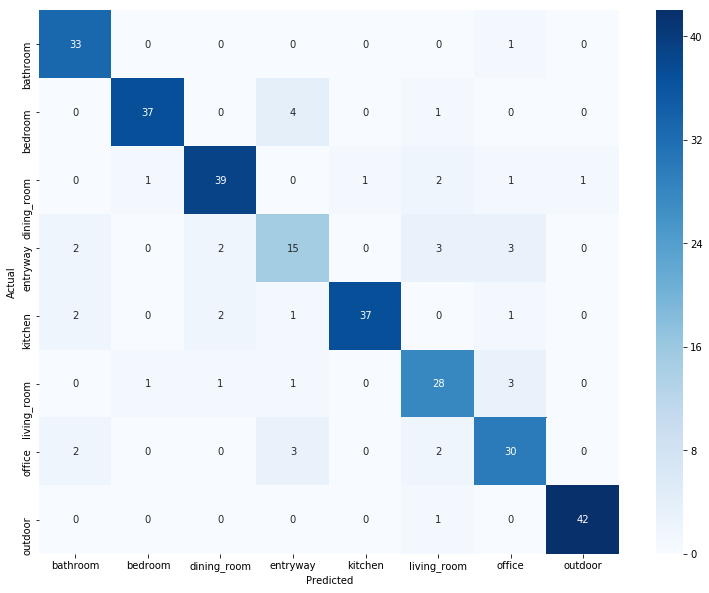

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

cmarray = confusion_matrix(trueValues, predValues, labels=classLabels)

df_cm = pd.DataFrame(cmarray, index = classLabels,
                  columns = classLabels)

plt.figure(figsize = (13,10))
ax = sn.heatmap(df_cm, annot=True, cmap="Blues")
ax.set(xlabel='Predicted', ylabel='Actual')

In [40]:
cm

array([[33,  0,  0,  0,  0,  0,  1,  0],
       [ 0, 37,  0,  4,  0,  1,  0,  0],
       [ 0,  1, 39,  0,  1,  2,  1,  1],
       [ 2,  0,  2, 15,  0,  3,  3,  0],
       [ 2,  0,  2,  1, 37,  0,  1,  0],
       [ 0,  1,  1,  1,  0, 28,  3,  0],
       [ 2,  0,  0,  3,  0,  2, 30,  0],
       [ 0,  0,  0,  0,  0,  1,  0, 42]])

In [13]:
# sgdwr
# lr 0.02
# mom 0.9
best_acc, model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=exp_lr_scheduler, num_epochs=120, cycle_mult=2)


Epoch 1/120
----------
train loss: 0.6326, acc: 0.7809
valid loss: 0.9737, acc: 0.7195
steps: 0 lr: 0.0200
1
steps: 782 lr: 0.0200
Epoch 2/120
----------
train loss: 0.7287, acc: 0.7566
valid loss: 0.8029, acc: 0.7360
steps: 391 lr: 0.0100
steps: 391 lr: 0.0100
Epoch 3/120
----------
train loss: 0.4648, acc: 0.8487
valid loss: 0.7042, acc: 0.7492
steps: 0 lr: 0.0000
2
steps: 1564 lr: 0.0200
Epoch 4/120
----------
train loss: 0.6912, acc: 0.7701
valid loss: 0.9500, acc: 0.6997
steps: 1173 lr: 0.0171
steps: 1173 lr: 0.0171
Epoch 5/120
----------
train loss: 0.5648, acc: 0.8174
valid loss: 0.8046, acc: 0.7459
steps: 782 lr: 0.0100
steps: 782 lr: 0.0100
Epoch 6/120
----------
train loss: 0.3745, acc: 0.8750
valid loss: 0.6919, acc: 0.7690
steps: 391 lr: 0.0029
steps: 391 lr: 0.0029
Epoch 7/120
----------
train loss: 0.2481, acc: 0.9239
valid loss: 0.6762, acc: 0.7756
steps: 0 lr: 0.0000
3
steps: 2346 lr: 0.0200
Epoch 8/120
----------
train loss: 0.6044, acc: 0.7934
valid loss: 0.8551, acc:

train loss: 0.0642, acc: 0.9843
valid loss: 0.7184, acc: 0.7888
steps: 3910 lr: 0.0138
steps: 3910 lr: 0.0138
Epoch 64/120
----------
train loss: 0.0555, acc: 0.9885
valid loss: 0.8223, acc: 0.7723
steps: 3519 lr: 0.0120
steps: 3519 lr: 0.0120
Epoch 65/120
----------
train loss: 0.0392, acc: 0.9914
valid loss: 0.8600, acc: 0.7789
steps: 3128 lr: 0.0100
steps: 3128 lr: 0.0100
Epoch 66/120
----------
train loss: 0.0298, acc: 0.9939
valid loss: 0.8017, acc: 0.7789
steps: 2737 lr: 0.0081
steps: 2737 lr: 0.0081
Epoch 67/120
----------
train loss: 0.0266, acc: 0.9939
valid loss: 0.7652, acc: 0.7921
steps: 2346 lr: 0.0062
steps: 2346 lr: 0.0062
Epoch 68/120
----------
train loss: 0.0218, acc: 0.9952
valid loss: 0.7526, acc: 0.8152
steps: 1955 lr: 0.0044
steps: 1955 lr: 0.0044
Epoch 69/120
----------
train loss: 0.0175, acc: 0.9968
valid loss: 0.7056, acc: 0.8020
steps: 1564 lr: 0.0029
steps: 1564 lr: 0.0029
Epoch 70/120
----------
train loss: 0.0196, acc: 0.9949
valid loss: 0.7031, acc: 0.821

In [14]:
torch.save(model_trained,'room_classifier0zwx43qw.pth')

In [159]:
!du -sh *.pth

4.0K	room_classifier.pth
4.0K	room_classifier0zwx43qw.pth
4.0K	room_classifier2.pth
4.0K	room_classifier3.pth
4.0K	room_classifierlr2e-2regular.pth
91M	roomclassifierd61d94g7.pth
91M	roomclassifierdgupdu59.pth
91M	roomclassifierfn1xqkbh.pth
91M	roomclassifierfsb8sukn.pth
91M	roomclassifierjw0x9qpx.pth
91M	roomclassifiermensrhso.pth
91M	roomclassifiermensrhsomtbz5bf8.pth
91M	roomclassifiero4mp46rv.pth
91M	testsave.pth
91M	testsavea.pth


In [23]:
# sgd
# lr 0.04
# wd 1e-3, mom 0.5
model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=exp_lr_scheduler, num_epochs=100, cycle_mult=2)


Epoch 1/100
----------
train loss: 1.4430, acc: 0.4934
valid loss: 1.2199, acc: 0.5908
Epoch 2/100
----------
train loss: 1.1164, acc: 0.6140
valid loss: 1.2407, acc: 0.5776
Epoch 3/100
----------
train loss: 0.9594, acc: 0.6789
valid loss: 0.8487, acc: 0.7030
Epoch 4/100
----------
train loss: 0.8500, acc: 0.7026
valid loss: 0.9182, acc: 0.6601
Epoch 5/100
----------
train loss: 0.8059, acc: 0.7339
valid loss: 1.0327, acc: 0.6535
Epoch 6/100
----------
train loss: 0.7445, acc: 0.7483
valid loss: 0.8386, acc: 0.7228
Epoch 7/100
----------
train loss: 0.6838, acc: 0.7781
valid loss: 0.8549, acc: 0.7228
Epoch 8/100
----------
train loss: 0.6487, acc: 0.7835
valid loss: 0.9472, acc: 0.7129
Epoch 9/100
----------
train loss: 0.6143, acc: 0.8014
valid loss: 0.8453, acc: 0.7294
Epoch 10/100
----------
train loss: 0.5849, acc: 0.8072
valid loss: 0.7919, acc: 0.7558
Epoch 11/100
----------
train loss: 0.5959, acc: 0.8014
valid loss: 1.0540, acc: 0.6898
Epoch 12/100
----------
train loss: 0.561

train loss: 0.3029, acc: 0.9165
valid loss: 0.9048, acc: 0.7327
Epoch 95/100
----------
train loss: 0.3186, acc: 0.9041
valid loss: 1.0251, acc: 0.6964
Epoch 96/100
----------
train loss: 0.2731, acc: 0.9245
valid loss: 1.2173, acc: 0.6205
Epoch 97/100
----------
train loss: 0.2882, acc: 0.9239
valid loss: 1.2275, acc: 0.6469
Epoch 98/100
----------
train loss: 0.2871, acc: 0.9239
valid loss: 0.9353, acc: 0.7030
Epoch 99/100
----------
train loss: 0.3184, acc: 0.9124
valid loss: 1.0058, acc: 0.6931
Epoch 100/100
----------
train loss: 0.2758, acc: 0.9252
valid loss: 0.9177, acc: 0.7294


In [40]:
torch.save(model_trained,'roomclassifiero4mp46rv.pth')

In [53]:
# sgd
# LR 0.07 mom 0.5 wd 1e-4
model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=exp_lr_scheduler, num_epochs=100, cycle_mult=2)


Epoch 1/100
----------
train loss: 1.6415, acc: 0.4049
valid loss: 1.4189, acc: 0.4851
Epoch 2/100
----------
train loss: 1.2733, acc: 0.5526
valid loss: 1.2364, acc: 0.5710
Epoch 3/100
----------
train loss: 1.1270, acc: 0.6143
valid loss: 1.4781, acc: 0.5281
Epoch 4/100
----------
train loss: 0.9807, acc: 0.6713
valid loss: 1.2693, acc: 0.5974
Epoch 5/100
----------
train loss: 0.9600, acc: 0.6697
valid loss: 1.1332, acc: 0.6337
Epoch 6/100
----------
train loss: 0.8572, acc: 0.7090
valid loss: 0.9492, acc: 0.6667
Epoch 7/100
----------
train loss: 0.8228, acc: 0.7259
valid loss: 0.9079, acc: 0.7063
Epoch 8/100
----------
train loss: 0.7429, acc: 0.7477
valid loss: 0.8208, acc: 0.7030
Epoch 9/100
----------
train loss: 0.6868, acc: 0.7717
valid loss: 1.0799, acc: 0.6634
Epoch 10/100
----------
train loss: 0.6299, acc: 0.7889
valid loss: 0.8470, acc: 0.7195
Epoch 11/100
----------
train loss: 0.6027, acc: 0.7960
valid loss: 0.8835, acc: 0.7162
Epoch 12/100
----------
train loss: 0.554

train loss: 0.0410, acc: 0.9894
valid loss: 0.7760, acc: 0.7690
Epoch 95/100
----------
train loss: 0.0368, acc: 0.9910
valid loss: 0.8848, acc: 0.7723
Epoch 96/100
----------
train loss: 0.0253, acc: 0.9958
valid loss: 0.7887, acc: 0.7690
Epoch 97/100
----------
train loss: 0.0362, acc: 0.9914
valid loss: 0.9515, acc: 0.7393
Epoch 98/100
----------
train loss: 0.0725, acc: 0.9795
valid loss: 0.8768, acc: 0.7789
Epoch 99/100
----------
train loss: 0.1084, acc: 0.9683
valid loss: 0.9141, acc: 0.7426
Epoch 100/100
----------
train loss: 0.0609, acc: 0.9859
valid loss: 0.9030, acc: 0.7426


In [54]:
torch.save(model_trained,'roomclassifierd61d94g7.pth')

In [57]:
# sgd
# LR 0.06 --
model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train loss: 1.6077, acc: 0.4218
valid loss: 2.4986, acc: 0.2970
Epoch 2/100
----------
train loss: 1.2485, acc: 0.5654
valid loss: 1.3808, acc: 0.5347
Epoch 3/100
----------
train loss: 1.0792, acc: 0.6284
valid loss: 0.8973, acc: 0.7030
Epoch 4/100
----------
train loss: 0.9359, acc: 0.6757
valid loss: 1.4245, acc: 0.5842
Epoch 5/100
----------
train loss: 0.8619, acc: 0.6968
valid loss: 0.8538, acc: 0.6898
Epoch 6/100
----------
train loss: 0.7883, acc: 0.7349
valid loss: 1.0097, acc: 0.6634
Epoch 7/100
----------
train loss: 0.7091, acc: 0.7605
valid loss: 1.1751, acc: 0.6601
Epoch 8/100
----------
train loss: 0.6796, acc: 0.7742
valid loss: 0.9359, acc: 0.7162
Epoch 9/100
----------
train loss: 0.6281, acc: 0.7880
valid loss: 1.0054, acc: 0.6733
Epoch 10/100
----------
train loss: 0.5771, acc: 0.8164
valid loss: 1.0936, acc: 0.6601
Epoch 11/100
----------
train loss: 0.5324, acc: 0.8222
valid loss: 0.8841, acc: 0.7096
Epoch 12/100
----------
train loss: 0.494

train loss: 0.0437, acc: 0.9894
valid loss: 0.7940, acc: 0.7888
Epoch 95/100
----------
train loss: 0.0537, acc: 0.9850
valid loss: 0.9064, acc: 0.7690
Epoch 96/100
----------
train loss: 0.0591, acc: 0.9827
valid loss: 0.7452, acc: 0.7756
Epoch 97/100
----------
train loss: 0.0424, acc: 0.9901
valid loss: 0.7976, acc: 0.7756
Epoch 98/100
----------
train loss: 0.0510, acc: 0.9894
valid loss: 1.0071, acc: 0.7162
Epoch 99/100
----------
train loss: 0.0451, acc: 0.9901
valid loss: 0.8105, acc: 0.8086
Epoch 100/100
----------
train loss: 0.0305, acc: 0.9933
valid loss: 0.7709, acc: 0.7987


In [58]:
torch.save(model_trained,'roomclassifierjw0x9qpx.pth')

In [61]:
#sgd
#LR 0.05
model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train loss: 1.5011, acc: 0.4637
valid loss: 1.3025, acc: 0.5347
Epoch 2/100
----------
train loss: 1.1601, acc: 0.6073
valid loss: 0.9797, acc: 0.6766
Epoch 3/100
----------
train loss: 0.9888, acc: 0.6684
valid loss: 1.0652, acc: 0.6304
Epoch 4/100
----------
train loss: 0.8903, acc: 0.6984
valid loss: 1.1270, acc: 0.6403
Epoch 5/100
----------
train loss: 0.7900, acc: 0.7343
valid loss: 0.8147, acc: 0.7195
Epoch 6/100
----------
train loss: 0.7151, acc: 0.7672
valid loss: 0.7903, acc: 0.7162
Epoch 7/100
----------
train loss: 0.6628, acc: 0.7928
valid loss: 1.0088, acc: 0.6865
Epoch 8/100
----------
train loss: 0.6102, acc: 0.7909
valid loss: 0.9951, acc: 0.6931
Epoch 9/100
----------
train loss: 0.5796, acc: 0.8043
valid loss: 0.9306, acc: 0.7327
Epoch 10/100
----------
train loss: 0.5111, acc: 0.8315
valid loss: 0.8786, acc: 0.7129
Epoch 11/100
----------
train loss: 0.4647, acc: 0.8417
valid loss: 1.3184, acc: 0.6667
Epoch 12/100
----------
train loss: 0.432

train loss: 0.0317, acc: 0.9933
valid loss: 0.6584, acc: 0.8152
Epoch 95/100
----------
train loss: 0.1022, acc: 0.9687
valid loss: 0.8961, acc: 0.7690
Epoch 96/100
----------
train loss: 0.0521, acc: 0.9885
valid loss: 0.8539, acc: 0.7756
Epoch 97/100
----------
train loss: 0.0358, acc: 0.9923
valid loss: 0.8199, acc: 0.8020
Epoch 98/100
----------
train loss: 0.0453, acc: 0.9901
valid loss: 0.8233, acc: 0.7888
Epoch 99/100
----------
train loss: 0.0343, acc: 0.9920
valid loss: 0.6909, acc: 0.8119
Epoch 100/100
----------
train loss: 0.0797, acc: 0.9767
valid loss: 0.8167, acc: 0.7756


In [62]:
torch.save(model_trained,'roomclassifiermensrhso.pth')

In [13]:
#sgd
#LR 0.04
model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train loss: 0.3781, acc: 0.8794
valid loss: 0.8820, acc: 0.7096
Epoch 2/100
----------
train loss: 0.3253, acc: 0.8983
valid loss: 0.8797, acc: 0.7459
Epoch 3/100
----------
train loss: 0.2961, acc: 0.9057
valid loss: 0.7519, acc: 0.7690
Epoch 4/100
----------
train loss: 0.2726, acc: 0.9159
valid loss: 0.7435, acc: 0.7690
Epoch 5/100
----------
train loss: 0.2229, acc: 0.9332
valid loss: 0.7686, acc: 0.7888
Epoch 6/100
----------
train loss: 0.2287, acc: 0.9312
valid loss: 0.7515, acc: 0.7822
Epoch 7/100
----------
train loss: 0.1853, acc: 0.9460
valid loss: 0.8466, acc: 0.7657
Epoch 8/100
----------
train loss: 0.1689, acc: 0.9492
valid loss: 0.7711, acc: 0.7624
Epoch 9/100
----------
train loss: 0.1495, acc: 0.9578
valid loss: 0.7601, acc: 0.7723
Epoch 10/100
----------
train loss: 0.1654, acc: 0.9527
valid loss: 0.6509, acc: 0.7954
Epoch 11/100
----------
train loss: 0.1535, acc: 0.9549
valid loss: 0.8558, acc: 0.7888
Epoch 12/100
----------
train loss: 0.158

train loss: 0.0484, acc: 0.9888
valid loss: 0.7639, acc: 0.7855
Epoch 95/100
----------
train loss: 0.0413, acc: 0.9898
valid loss: 0.7888, acc: 0.7855
Epoch 96/100
----------
train loss: 0.0556, acc: 0.9837
valid loss: 0.8864, acc: 0.7921
Epoch 97/100
----------
train loss: 0.0554, acc: 0.9856
valid loss: 0.8684, acc: 0.7789
Epoch 98/100
----------
train loss: 0.0536, acc: 0.9866
valid loss: 0.7853, acc: 0.7855
Epoch 99/100
----------
train loss: 0.0494, acc: 0.9866
valid loss: 0.9417, acc: 0.7459
Epoch 100/100
----------
train loss: 0.0430, acc: 0.9901
valid loss: 0.7735, acc: 0.7855


In [14]:
torch.save(model_trained,'roomclassifiermensrhsomtbz5bf8.pth')

In [20]:
#sgd
#lr 0.03
model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=exp_lr_scheduler, num_epochs=100)

Epoch 1/100
----------
train loss: 0.2548, acc: 0.9178
valid loss: 0.7797, acc: 0.7921
Epoch 2/100
----------
train loss: 0.2513, acc: 0.9175
valid loss: 0.6481, acc: 0.7789
Epoch 3/100
----------
train loss: 0.2301, acc: 0.9322
valid loss: 0.6523, acc: 0.7690
Epoch 4/100
----------
train loss: 0.2266, acc: 0.9300
valid loss: 0.9113, acc: 0.7393
Epoch 5/100
----------
train loss: 0.1915, acc: 0.9450
valid loss: 0.7971, acc: 0.7690
Epoch 6/100
----------
train loss: 0.1751, acc: 0.9472
valid loss: 0.6945, acc: 0.7954
Epoch 7/100
----------
train loss: 0.1511, acc: 0.9581
valid loss: 0.6829, acc: 0.7987
Epoch 8/100
----------
train loss: 0.1411, acc: 0.9632
valid loss: 0.8980, acc: 0.7492
Epoch 9/100
----------
train loss: 0.1414, acc: 0.9591
valid loss: 0.9169, acc: 0.7426
Epoch 10/100
----------
train loss: 0.1517, acc: 0.9584
valid loss: 0.6927, acc: 0.8086
Epoch 11/100
----------
train loss: 0.0888, acc: 0.9776
valid loss: 0.6798, acc: 0.8086
Epoch 12/100
----------
train loss: 0.100

train loss: 0.0200, acc: 0.9958
valid loss: 0.7896, acc: 0.8053
Epoch 95/100
----------
train loss: 0.0104, acc: 0.9994
valid loss: 0.8058, acc: 0.7855
Epoch 96/100
----------
train loss: 0.0072, acc: 0.9997
valid loss: 0.7585, acc: 0.8185
Epoch 97/100
----------
train loss: 0.0070, acc: 0.9997
valid loss: 0.7587, acc: 0.8152
Epoch 98/100
----------
train loss: 0.0139, acc: 0.9978
valid loss: 0.7316, acc: 0.8251
Epoch 99/100
----------
train loss: 0.0076, acc: 0.9994
valid loss: 0.6956, acc: 0.8119
Epoch 100/100
----------
train loss: 0.0069, acc: 0.9997
valid loss: 0.7355, acc: 0.8086


In [21]:
torch.save(model_trained,'roomclassifierfn1xqkbh.pth')

In [35]:
#sgd
#lr 0.01
model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=exp_lr_scheduler, num_epochs=45)

Epoch 1/100
----------
train loss: 1.6578, acc: 0.4317
valid loss: 1.0617, acc: 0.6700
Epoch 2/100
----------
train loss: 1.0345, acc: 0.6613
valid loss: 0.7347, acc: 0.7690
Epoch 3/100
----------
train loss: 0.7628, acc: 0.7627
valid loss: 0.6145, acc: 0.8020
Epoch 4/100
----------
train loss: 0.6067, acc: 0.8200
valid loss: 0.5212, acc: 0.8515
Epoch 5/100
----------
train loss: 0.5186, acc: 0.8443
valid loss: 0.5112, acc: 0.8383
Epoch 6/100
----------
train loss: 0.4283, acc: 0.8791
valid loss: 0.5206, acc: 0.8251
Epoch 7/100
----------
train loss: 0.3437, acc: 0.9015
valid loss: 0.5123, acc: 0.8350
Epoch 8/100
----------
train loss: 0.2877, acc: 0.9175
valid loss: 0.5233, acc: 0.8383
Epoch 9/100
----------
train loss: 0.2508, acc: 0.9319
valid loss: 0.5340, acc: 0.8218
Epoch 10/100
----------
train loss: 0.2035, acc: 0.9536
valid loss: 0.5167, acc: 0.8449
Epoch 11/100
----------
train loss: 0.1820, acc: 0.9587
valid loss: 0.5018, acc: 0.8350
Epoch 12/100
----------
train loss: 0.160

KeyboardInterrupt: 

In [27]:
#AdamW -> Run this one
model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=exp_lr_scheduler, num_epochs=75)

Epoch 1/75
----------
steps: 0 lr: 0.00000000
valid loss: 1.4664, acc: 0.5446
Epoch 2/75
----------
steps: 0 lr: 0.00000000
valid loss: 1.0685, acc: 0.6898
Epoch 3/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.8681, acc: 0.7624
Epoch 4/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.7197, acc: 0.7954
Epoch 5/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.6285, acc: 0.8119
Epoch 6/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.5936, acc: 0.8251
Epoch 7/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.5329, acc: 0.8515
Epoch 8/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.5290, acc: 0.8515
Epoch 9/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.5503, acc: 0.8119
Epoch 10/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.5280, acc: 0.8152
Epoch 11/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.4937, acc: 0.8515
Epoch 12/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.5011, acc: 0.8185
Epoch 13/75
----------
steps: 0 lr: 0.00000000
valid loss: 0.

In [10]:
model.load_state_dict(torch.load('testsave.pt'))
model.eval()

RuntimeError: Error(s) in loading state_dict for ResNet:
	While copying the parameter named "conv1.weight", whose dimensions in the model are torch.Size([64, 3, 7, 7]) and whose dimensions in the checkpoint are torch.Size([64, 3, 7, 7]).

In [29]:
torch.save(model_trained, 'RoomClassifier86.pth')

In [114]:
#AdamW constant learning rate at 1e-5
model_trained = train_model(model, criterion, optimizer, dataloaders, scheduler=None, num_epochs=100)

Epoch 1/100
----------
valid loss: 1.1300, acc: 0.6238
Epoch 2/100
----------
valid loss: 0.7879, acc: 0.7492
Epoch 3/100
----------
valid loss: 0.6239, acc: 0.8152
Epoch 4/100
----------
valid loss: 0.5654, acc: 0.8350
Epoch 5/100
----------
valid loss: 0.5359, acc: 0.8251
Epoch 6/100
----------
valid loss: 0.4949, acc: 0.8350
Epoch 7/100
----------
valid loss: 0.5121, acc: 0.8251
Epoch 8/100
----------
valid loss: 0.5022, acc: 0.8251
Epoch 9/100
----------
valid loss: 0.5163, acc: 0.8251
Epoch 10/100
----------
valid loss: 0.5242, acc: 0.8284
Epoch 11/100
----------
valid loss: 0.5182, acc: 0.8515
Epoch 12/100
----------
valid loss: 0.5318, acc: 0.8548
Epoch 13/100
----------
valid loss: 0.5297, acc: 0.8548
Epoch 14/100
----------
valid loss: 0.5249, acc: 0.8416
Epoch 15/100
----------
valid loss: 0.5581, acc: 0.8350
Epoch 16/100
----------
valid loss: 0.5545, acc: 0.8449
Epoch 17/100
----------
valid loss: 0.5056, acc: 0.8614
Epoch 18/100
----------
valid loss: 0.5081, acc: 0.8581
E

requests_with_retry encountered retryable exception: ('Connection aborted.', OSError("(104, 'ECONNRESET')",)). args: ('https://api.wandb.ai/homedepot/homedepot/te64cyns/file_stream',), kwargs: {'json': {'files': {'output.log': {'offset': 192, 'content': ['2019-03-11T19:55:07.203346 valid loss: 0.5975, acc: 0.8416\n', '2019-03-11T19:55:07.203542 Epoch 66/100\n', '2019-03-11T19:55:07.203601 ----------\n', '2019-03-11T19:55:29.706986 valid loss: 0.6152, acc: 0.8416\n', '2019-03-11T19:55:29.707346 Epoch 67/100\n', '2019-03-11T19:55:29.707435 ----------\n']}, 'wandb-events.jsonl': {'offset': 48, 'content': ['{"system.gpu.0.gpu": 59.27, "system.gpu.0.memory": 27.4, "system.gpu.0.memory_allocated": 61.5, "system.gpu.0.temp": 49.87, "system.cpu": 55.62, "system.memory": 8.23, "system.disk": 6.6, "system.proc.memory.availableMB": 48020.33, "system.proc.memory.rssMB": 3374.06, "system.proc.memory.percent": 6.45, "system.proc.cpu.threads": 25.0, "system.network.sent": 1604463, "system.network.rec

valid loss: 0.5749, acc: 0.8416
Epoch 68/100
----------
valid loss: 0.5958, acc: 0.8515
Epoch 69/100
----------
valid loss: 0.5911, acc: 0.8416
Epoch 70/100
----------
valid loss: 0.6404, acc: 0.8416
Epoch 71/100
----------
valid loss: 0.6206, acc: 0.8416
Epoch 72/100
----------
valid loss: 0.5969, acc: 0.8515
Epoch 73/100
----------
valid loss: 0.6010, acc: 0.8449
Epoch 74/100
----------
valid loss: 0.5962, acc: 0.8317
Epoch 75/100
----------
valid loss: 0.6392, acc: 0.8218
Epoch 76/100
----------
valid loss: 0.6121, acc: 0.8317
Epoch 77/100
----------
valid loss: 0.6188, acc: 0.8284
Epoch 78/100
----------
valid loss: 0.5735, acc: 0.8251
Epoch 79/100
----------
valid loss: 0.6542, acc: 0.8251
Epoch 80/100
----------
valid loss: 0.6034, acc: 0.8218
Epoch 81/100
----------
valid loss: 0.6070, acc: 0.8383
Epoch 82/100
----------
valid loss: 0.6207, acc: 0.8317
Epoch 83/100
----------
valid loss: 0.6551, acc: 0.8482
Epoch 84/100
----------
valid loss: 0.6207, acc: 0.8317
Epoch 85/100
---